# Earth Mover's distances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE

In [2]:
spectra = pd.read_csv("markeddata/normalized_spectra.txt")
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,gev_1FGL_Name,tev_fermi_names,marked
0,0.013537,0.343081,0.020826,0.143005,0.330419,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.022171,0.017989,0.012135,0.004136,0.000407,b'SSTGC 519103',b' ',b'',0
1,0.013335,0.013325,0.000805,0.014451,0.004808,0.0,0.0,0.004396,0.019638,0.0,...,0.0,0.005775,0.012273,0.007655,0.004429,0.002622,b'LS IV -05 11',b' ',b'',0
2,0.001682,0.042624,0.002587,0.017767,0.041051,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.002754,0.002235,0.001508,0.000514,0.000051,b'GCIRS 1W',b' ',b'',0
3,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.005744,0.000322,0.000969,0.000719,0.001111,b'[MCD2010] 18',b'1FGL J1746.4-2849c',b'',0
4,0.012809,0.324638,0.019706,0.135318,0.312657,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.020979,0.017022,0.011482,0.003914,0.000385,b'GCIRS 8',b' ',b'',0


In [3]:
spectrum_columns = spectra.columns[:-4]

Computation of pairwise distances (metric - Earth mover's distance (Wasserstein distance))

In [4]:
dist = DistanceMetric.get_metric("pyfunc", func=st.wasserstein_distance)
spectra_distances = dist.pairwise(spectra[spectrum_columns])
pd.DataFrame(spectra_distances).to_csv("markeddata/spectra_EM_distances.txt", index=False)

Vizualization (mapping to 2D-plane)

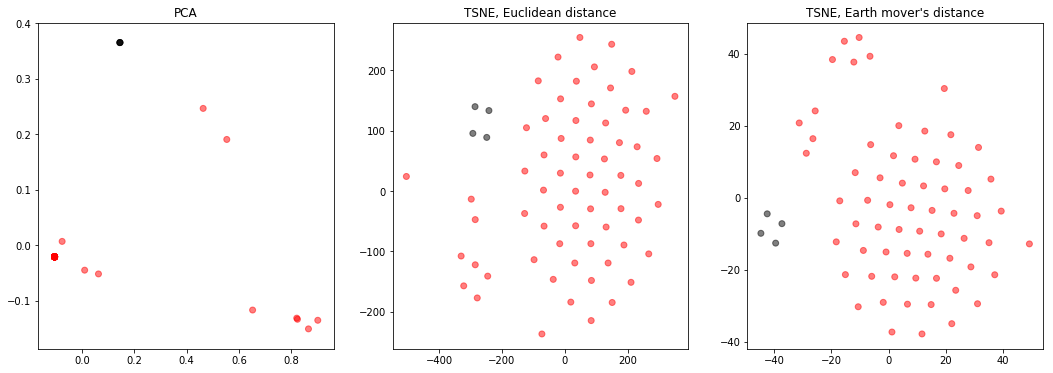

In [5]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Earth mover's distance")
tsne = TSNE(n_components=2, metric=st.wasserstein_distance, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

KMeans clustering (with Earth mover's distance metric)

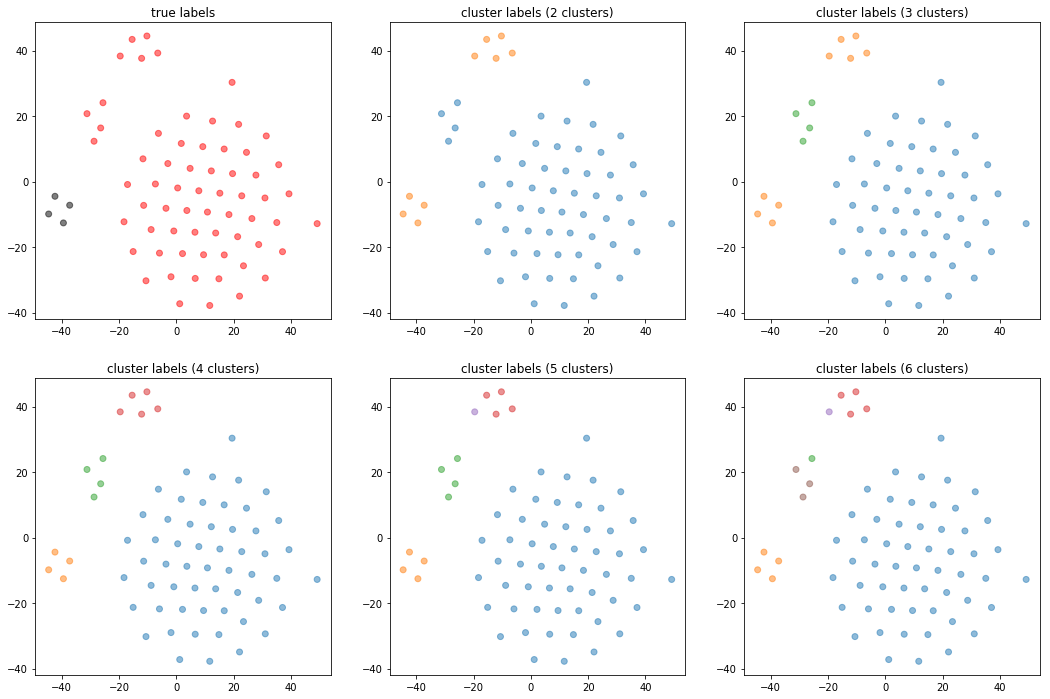

In [6]:
# visualization - tsne with Earth mover's distance
tsne = TSNE(n_components=2, metric=st.wasserstein_distance, random_state=42)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

plt.subplots(figsize=(18, 12))
plt.subplot(2, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for n in range(2, 7):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)

    plt.subplot(2, 3, n)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels ({} clusters)".format(n))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    
plt.show()

In [7]:
n = 4

kmeans = cluster.KMeans(n_clusters=n, random_state=42)
cluster_labels = kmeans.fit_predict(spectra_distances)

spectra['KMeans_clusters_' + str(n)] = cluster_labels
for i in range(n):
    print("{} cluster".format(i))
    display(spectra[spectra['KMeans_clusters_' + str(n)] == i][['s_MAIN_ID', 'gev_1FGL_Name', 'tev_fermi_names']])

0 cluster


,s_MAIN_ID,gev_1FGL_Name,tev_fermi_names
10,b'[CHP2004] J095549.8+693934',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
11,b'[MTK2001b] 8',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
12,b'[CHP2004] J095637.5+694137',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
13,b'CXOU J095601.7+694308',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
14,b'CXOU J095548.9+694010',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
15,b'CXOU J095527.1+693923',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
16,b'CXOU J095552.8+694020',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
17,b'CXOU J095552.4+694024',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
18,b'CXOU J095550.7+694039',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."
19,b'CXOU J095547.5+694120',b'1FGL J0956.5+6938 ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09..."


1 cluster


,s_MAIN_ID,gev_1FGL_Name,tev_fermi_names
7,b'[MT91] 213',b'1FGL J2032.2+4127 ',b''
9,b'LS I +61 303',b'1FGL J0240.5+6113 ',b''
38,b'2FGL J1019.0-5856',b'1FGL J1018.6-5856 ',b'1FGL J1018.6-5856'
60,b'V* V479 Sct',b'1FGL J1826.2-1450 ',b''


2 cluster


,s_MAIN_ID,gev_1FGL_Name,tev_fermi_names
0,b'SSTGC 519103',b' ',b''
1,b'LS IV -05 11',b' ',b''
4,b'GCIRS 8',b' ',b''
8,b'Schulte 21',b'1FGL J2032.2+4127 ',b''


3 cluster


,s_MAIN_ID,gev_1FGL_Name,tev_fermi_names
2,b'GCIRS 1W',b' ',b''
3,b'[MCD2010] 18',b'1FGL J1746.4-2849c',b''
5,b'[MCD2010] 13',b'1FGL J1746.4-2849c',b''
6,b'[MCD2010] 13',b'1FGL J1746.4-2849c',b''
56,b'[KRL2007b] 332',b' ',b''
